## Fine tuning on pre-trained keras model InceptionV3


In [ ]:
import os 

import numpy as np
from matplotlib import pyplot
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import SGD
from keras import callbacks
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib import pyplot
import seaborn as sns

### Paths to preprocessed balanced data

In [ ]:
#path = "/home/ubuntu/nbs/data/seedlings"
path ="/home/ubuntu/nbs/data/balanced_preprocessed_seedlings"
train_path = os.path.join(path, "train_preproc")
valid_path = os.path.join(path, "valid_preproc")
test_path = os.path.join(path, "test")
preview_path = os.path.join(path, "preview")
checkpoint_path = os.path.join(path, "best_weights.hdf5")

### Data generator with augmentation

In [4]:
# Get batches from the dirname directory, perform augmentation (rotation, shift, flip, zoom) 
# and return batch genarator object.
def get_batches(dirname, shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(299,299)):
    gen = image.ImageDataGenerator(
                        rotation_range=180, 
                        #width_shift_range=0.1, height_shift_range=0.1, 
                        horizontal_flip=True, vertical_flip=True,
                        #zoom_range=0.2,
                        preprocessing_function=preprocess_input
                        )
    flow = gen.flow_from_directory(
                        dirname, 
                        shuffle=True,
                        batch_size=batch_size, 
                        class_mode='categorical',
                        target_size=target_size,
                        )

    return flow 

### Take a look at augmented images

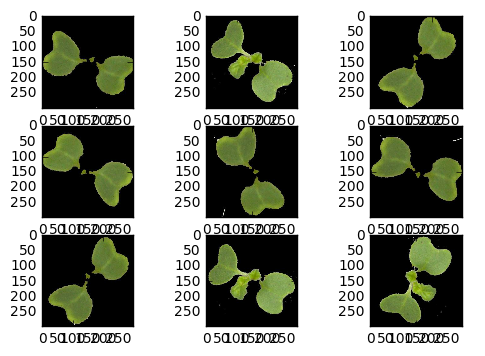

In [6]:
#Take a look at augmented images
gen = image.ImageDataGenerator(
                        rotation_range=180, 
                        #width_shift_range=0.1, height_shift_range=0.1, 
                        horizontal_flip=True, vertical_flip=True,
                       # zoom_range=0.2,
                        preprocessing_function=preprocess_input
                        )

img = image.load_img(os.path.join(train_path, 'Charlock/_208_5733456.png'))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
for z in range(6):
    batch = next(gen.flow(x, save_to_dir=preview_path, save_prefix='Black_grass', save_format='jpeg'))
    
for i, pic in enumerate(os.listdir(preview_path)[:9]):
    img = image.load_img(os.path.join(preview_path, pic))
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(img)
pyplot.show()

### Updating InceptionV3 model

In [7]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer (12 classes)
predictions = Dense(12, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# train only the top layers
# freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

### Creating callbacks (early stopping and checkpoint)

In [8]:
# Early stop training if loss starts to increase duaring 2 epochs. Check point best models.
model_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=0),
    callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=0),
]

### Train top level of model 

In [9]:
# get train and valid augmented data generators
batch_size = 64
train_batches = get_batches(train_path, batch_size=batch_size)
valid_batches = get_batches(valid_path, batch_size=batch_size)
# train model
model.fit_generator(train_batches,
                    epochs=30, 
                    validation_data=valid_batches, 
                    steps_per_epoch=10000/batch_size, 
                    validation_steps=2500/batch_size,
                    callbacks=model_callbacks,
                   )

Found 6000 images belonging to 12 classes.
Found 2400 images belonging to 12 classes.
Epoch 1/30
156/156 [==============================] - 222s 1s/step - loss: 1.8501 - acc: 0.5202 - val_loss: 0.8494 - val_acc: 0.6907
Epoch 2/30
156/156 [==============================] - 208s 1s/step - loss: 0.7807 - acc: 0.7218 - val_loss: 0.5662 - val_acc: 0.7995
Epoch 3/30
156/156 [==============================] - 205s 1s/step - loss: 0.6264 - acc: 0.7742 - val_loss: 0.5533 - val_acc: 0.8121
Epoch 4/30
156/156 [==============================] - 214s 1s/step - loss: 0.5299 - acc: 0.8009 - val_loss: 0.4467 - val_acc: 0.8381
Epoch 5/30
156/156 [==============================] - 210s 1s/step - loss: 0.5025 - acc: 0.8125 - val_loss: 0.4873 - val_acc: 0.8251
Epoch 6/30
156/156 [==============================] - 202s 1s/step - loss: 0.4606 - acc: 0.8340 - val_loss: 0.4195 - val_acc: 0.8450
Epoch 7/30
156/156 [==============================] - 212s 1s/step - loss: 0.4126 - acc: 0.8479 - val_loss: 0.5665 -

### Fine-tuning convolutional layers

In [10]:
# top layers are well trained, can start fine-tuning 
print("Number of InceptionV3 layers {}".format(len(base_model.layers)))
# freeze the first 249 layers and unfreeze the rest
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

#recompile the model with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])


# Callbacks (early stop training if loss starts to increase duaring 2 epochs. Check point best models.)
model_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=0),
    callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=0),
]
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(train_batches, 
                    epochs=30, 
                    validation_data=valid_batches, 
                    callbacks=model_callbacks, 
                    steps_per_epoch=10000/batch_size, 
                    validation_steps=2500/batch_size)

Number of InceptionV3 layers 311
Epoch 1/30
156/156 [==============================] - 218s 1s/step - loss: 0.2229 - acc: 0.9152 - val_loss: 0.3527 - val_acc: 0.8900
Epoch 2/30
156/156 [==============================] - 216s 1s/step - loss: 0.1779 - acc: 0.9308 - val_loss: 0.3443 - val_acc: 0.8876
Epoch 3/30
156/156 [==============================] - 210s 1s/step - loss: 0.1684 - acc: 0.9366 - val_loss: 0.3388 - val_acc: 0.8912
Epoch 4/30
156/156 [==============================] - 220s 1s/step - loss: 0.1666 - acc: 0.9357 - val_loss: 0.3250 - val_acc: 0.8961
Epoch 5/30
156/156 [==============================] - 216s 1s/step - loss: 0.1570 - acc: 0.9370 - val_loss: 0.3236 - val_acc: 0.8961
Epoch 6/30
156/156 [==============================] - 211s 1s/step - loss: 0.1510 - acc: 0.9402 - val_loss: 0.3128 - val_acc: 0.8989
Epoch 7/30
156/156 [==============================] - 213s 1s/step - loss: 0.1486 - acc: 0.9411 - val_loss: 0.3180 - val_acc: 0.8973
Epoch 8/30
156/156 [================

In [18]:
scores = model.evaluate_generator(valid_batches, steps=2500/batch_size)
print("Accuracy {}".format(scores[1]))
print("Loss {}".format(scores[0]))

Accuracy 0.898133116883
Loss 0.315513543688
